# 🎙️ L4-A: Speech Features

---

Welcome to the first lab (L4) about speech recognition! L4 is divided in 2 parts, each dedicated to different topics:
- **L4-A) Speech Features** 🌊
- L4-B) Speech Recognition - Connectionist Temporal Classification 🕰️

In this colab, L4-A, we will learn the basics about features used for speech tasks. This will be the first stepping stone before we dive deep into speech recognition (and synthesis, but that will be another day).

Get ready to learn how to load audio waveforms into tensors, and how to compute the most relevant features for speech processing, the spectrograms!


## 📦 Imports

First, we will use **pip** to install **torchaudio**, a library built on top of **PyTorch**, that allows to load audio directly into **torch** tensors, allowing for fast and efficient usage in neural networks and Graphical Processing Units (GPU)! 🔥

In [12]:
!pip install torchaudio

Now, let's import some libraries that we will use for math and tensor operations (**numpy**, **torch**), as well as **torchaudio** and some plotting utilities (**librosa.display**, **matplotlib**, **IPython**).

In [13]:
#test save collab
# Math & tensor libs
import numpy as np
import torch

# Audio backend
import torchaudio

# Plotting libs
import librosa.display
import matplotlib.pyplot as plt
import IPython

## 💾 Dataset

We just need to download some speech audio files. In this case, we will use audio from the Google Speech Commands dataset, which contains recordings of simple voice commands like "stop", "go", "yes", "no", etc.

In [19]:
# Torchaudio provides a function to directly download this data. Download could take 1-2 minutes.
# You can visit the documentation for more information - https://pytorch.org/audio/stable/generated/torchaudio.datasets.SPEECHCOMMANDS.html#torchaudio.datasets.SPEECHCOMMANDS
dataset = torchaudio.datasets.SPEECHCOMMANDS(
    root='./',
    url='speech_commands_v0.01',
    download=True,
    subset='testing',
)

In [22]:
# This dataset contains many files, how do we get one?
# We can use __getitem__ function, which takes the number/id of the sample we want to retrieve
sample_id = 0
sample = dataset.__getitem__(sample_id)

In [23]:
sample

(tensor([[0.0074, 0.0092, 0.0164,  ..., 0.0289, 0.0285, 0.0243]]),
 16000,
 'bed',
 '0c40e715',
 0)

That's not really easy to understand, right? You can take a look at the documentation to understand what is returned there, [click on this link](https://pytorch.org/audio/stable/generated/torchaudio.datasets.SPEECHCOMMANDS.html#torchaudio.datasets.SPEECHCOMMANDS).

Basically, we have:
- I) a tensor containing the audio waveform
- II) the sampling rate
- III) the label, what is being said in the audio
- IV) the identity of the speaker
- V) the identifier of the utterance

Let's familiarize ourselves with each concept!

## 🎧 Audio visualization

In [24]:
audio, sampling_rate, label, speaker_id, utterance_id = sample

Shape of the audio tensor = torch.Size([1, 16000])
You see it has two dimensions: The first = 1 and the second = 16000
The first corresponds to the number of channels, in this case 1, because it is a mono audio. It would be 2, if it was stereo, as the songs you listen daily!
The second is the temporal length, meaning that our audio is represented by 16000 numbers. Because our sampling rate is 16000 Hz, it means that 16000 / 16000 = 1 second
___________________________

Let's visualize and listen to the audio! You can see that the audio lasts 1 second indeed.
Also, pay attention to what is being said, it should correspond to the label = bed


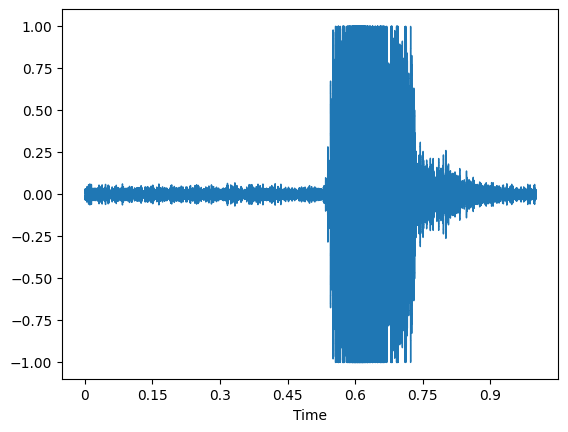

In [25]:
# Starting with the audio, we have it stored on a torch tensor. We can visualize a few characteristics of it.
audio_shape = audio.shape
print(f"Shape of the audio tensor = {audio_shape}")
print(f"You see it has two dimensions: The first = {audio_shape[0]} and the second = {audio_shape[1]}")
print(f"The first corresponds to the number of channels, in this case 1, because it is a mono audio. It would be 2, if it was stereo, as the songs you listen daily!")
print(f"The second is the temporal length, meaning that our audio is represented by {audio_shape[1]} numbers. Because our sampling rate is 16000 Hz, it means that {audio_shape[1]} / 16000 = 1 second")
print("___________________________\n")
print("Let's visualize and listen to the audio! You can see that the audio lasts 1 second indeed.")
print(f"Also, pay attention to what is being said, it should correspond to the label = {label}")

librosa.display.waveshow(audio.numpy(), sr=sampling_rate)
IPython.display.Audio(audio, rate=sampling_rate)

Let's play with the sampling rate to get familiarized with such concept.

The sampling rate means how many numbers (or samples) you need to codify one second of audio, and it is measured in Hertz = Hz.

As the previous sample has sample rate of 16000 Hz, we had to inform that to the visualization library.

What if we input that the sampling rate is, for instance, 8000 Hz? Input waveform has 16000 samples, so 16000 / 8000 = 2 seconds.

The library will interpret that the audio is two seconds long, which is wrong, and it will sound slowed down...

In [26]:
IPython.display.Audio(audio, rate=8000)

Likewise, if we input a higher sampling rate, like 32000 Hz, the audio will sound sped up.

In [27]:
IPython.display.Audio(audio, rate=32000)

**Lesson** - it is important to know what is the sampling rate of our recorded audio, and adapt our data processing pipeline to match it!

Feel free to go back and modify `sample_id = 0`, (e.g. `sample_id = 1`), and rerun the previous cells to inspect other samples.

## ⛏️ Speech features extraction

Now, let's extract the most commonly used features for speech processing. Summarizing:
- I) The waveform contains the most information, but is costly to process. You see, 16000 samples to characterize someone saying "bed"! In text, "bed" only has 3 characters... 16000 >> 3, so in complexity audio >> text 😯
- II) The spectrogram (or Short-Time Fourier Transform = STFT), means decomposing 1D audio (time) into a 2D matrix of (frequency, time). This feature contains more explicit information and is more compressed, easier to process.
- III) The mel-spectrogram is a very popular choice, where we filter the spectrogram to enhance and reduce certain frequencies, according to how the human ear perceives them.
- IV) The MFCC (Mel Frequency Cepstral Coefficients) is a further step of compressing even more the mel-spectrogram, making it more efficient to process, especially for shallow neural networks, at the cost of some information lost.

### 🌊 The waveform

We already inspected the waveform before. Thanks to **torchaudio**, we downloaded a waveform in a tensor format.

What if we want to save our waveform tensor to our local disk? You may use **torchaudio.save** for that.

In [28]:
!ls

sample_data  SpeechCommands  speech_commands_v0.01.tar.gz  waveform_0.wav


In [29]:
waveform_local_path = "./waveform_0.wav"  #: the local path where we save the audio
audio_to_save = audio #: the tensor to be saved as a wav file
output_sampling_rate = sampling_rate #: the sampling rate at which we save the audio
torchaudio.save(uri=waveform_local_path, src=audio_to_save, sample_rate=output_sampling_rate)
!ls

sample_data  SpeechCommands  speech_commands_v0.01.tar.gz  waveform_0.wav


As you can see, the audio is saved now in our local disk!
Before, we downloaded the audio tensor directly from the Internet, thanks to torchaudio. But what if we want to read a waveform that is stored locally in our disk, and put it into a torch tensor?

✍️ **TASK 1** (+0.75/10) - Load the audio waveform that you just stored in the local disk, into a torch tensor. Use **torchaudio.load** function for that, [see the documentation here.](https://pytorch.org/audio/stable/generated/torchaudio.load.html#torchaudio.load)

/usr/local/lib/python3.12/dist-packages/torchaudio/_backend/utils.py:213: UserWarning: In 2.9, this function's implementation will be changed to use torchaudio.load_with_torchcodec` under the hood. Some parameters like ``normalize``, ``format``, ``buffer_size``, and ``backend`` will be ignored. We recommend that you port your code to rely directly on TorchCodec's decoder instead: https://docs.pytorch.org/torchcodec/stable/generated/torchcodec.decoders.AudioDecoder.html#torchcodec.decoders.AudioDecoder.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchaudio/_backend/ffmpeg.py:88: UserWarning: torio.io._streaming_media_decoder.StreamingMediaDecoder has been deprecated. This deprecation is part of a large refactoring effort to transition TorchAudio into a maintenance phase. The decoding and encoding capabilities of PyTorch for both audio and video are being consolidated into TorchCodec. Please see https://github.com/pytorch/audio/issues/3902 for more information. It will be r

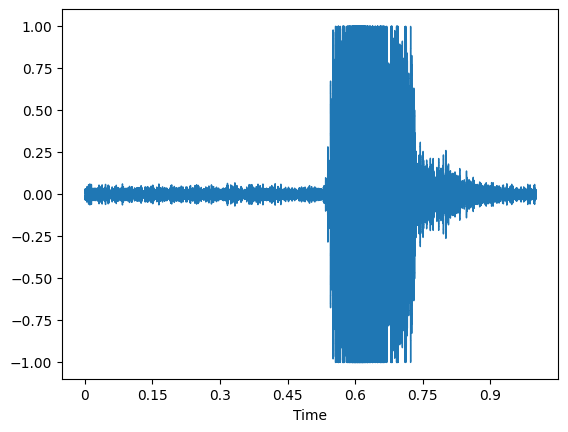

In [30]:
def load_audio(path):
  # TASK 1: Implement audio waveform loading with Torchaudio here.
  waveform, waveform_sampling_rate = torchaudio.load(path)# None, None
  return waveform, waveform_sampling_rate

waveform, waveform_sampling_rate = load_audio(waveform_local_path)

# You'll have to pass these tests to ensure that you loaded the audio correctly.
assert torch.is_tensor(waveform), f"Error! waveform is not a torch tensor, is: {type(waveform)}."
assert waveform.shape == (1, 16000), f"Error! The waveform shape detected is: {waveform.shape}"
assert waveform_sampling_rate == 16000, f"Error! The waveform sampling rate is not the expected one: {waveform_sampling_rate}"

librosa.display.waveshow(waveform.numpy(), sr=waveform_sampling_rate)
IPython.display.Audio(waveform, rate=waveform_sampling_rate)

✍️ **TASK 2** (+0.75/10) - Now, let's extract the spectrogram or STFT from the waveform. Use **torchaudio.transforms.Spectrogram** function for that, [see the documentation here.](https://pytorch.org/audio/main/generated/torchaudio.transforms.Spectrogram.html#torchaudio.transforms.Spectrogram)

Spectrogram shape is torch.Size([1, 201, 81])
Dimension 0 is 1, which means there is one spectrogram in this tensor batch.
Dimension 1 is 201, which means that there are 201 frequency bins.
Dimension 2 is 81, which means that there are 81 temporal frames.


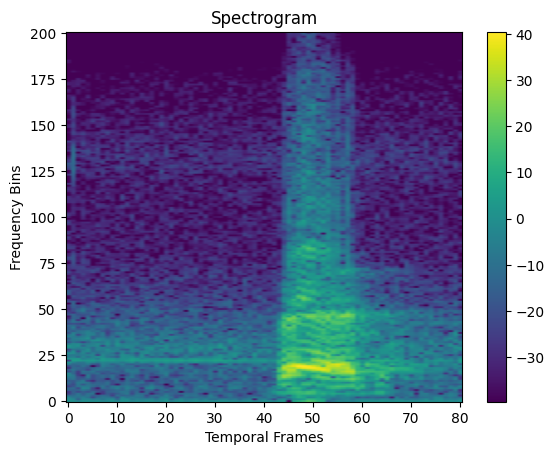

In [31]:
def extract_spectrogram(wav, n_fft, win_length, hop_length):
  # TASK 2: Implement spectrogram extractor here.
  spectrogram_extractor = torchaudio.transforms.Spectrogram(n_fft=n_fft, win_length=win_length, hop_length=hop_length)
  spectrogram = spectrogram_extractor(wav)
  return spectrogram

# Utility function to visualize spectrograms.
def plot_spectrogram(spec, title=None, ylabel='Frequency Bins', aspect='auto', xmax=None):
  fig, axs = plt.subplots(1, 1)
  axs.set_title(title or 'Spectrogram (db)')
  axs.set_ylabel(ylabel)
  axs.set_xlabel('Temporal Frames')
  im = axs.imshow(librosa.power_to_db(spec), origin='lower', aspect=aspect)
  if xmax:
    axs.set_xlim((0, xmax))
  fig.colorbar(im, ax=axs)
  plt.show(block=False)

# Arguments required for spectrogram computation. Feel free to play with them.
N_FFT = 400  # Number of Fast Fourier Transformer (FFT) points. Controls frequency resolution. Higher value gives more detail in frequency, but lower time resolution.
WIN_LENGTH = 400  # Window size in samples. Determines the length of each segment analyzed by the FFT.
HOP_LENGTH = 200  # Step size between windows in samples. Controls overlap between segments. Smaller values increase overlap, capturing smoother transitions.

spectrogram = extract_spectrogram(waveform, n_fft=N_FFT, win_length=WIN_LENGTH, hop_length=HOP_LENGTH)

assert len(spectrogram.shape) == 3

print(f"Spectrogram shape is {spectrogram.shape}")
print(f"Dimension 0 is {spectrogram.shape[0]}, which means there is one spectrogram in this tensor batch.")
print(f"Dimension 1 is {spectrogram.shape[1]}, which means that there are {spectrogram.shape[1]} frequency bins.")
print(f"Dimension 2 is {spectrogram.shape[2]}, which means that there are {spectrogram.shape[2]} temporal frames.")

plot_spectrogram(spectrogram[0, :, :], title="Spectrogram")

✍️ **TASK 3** (+0.75/10) - Now, let's apply the mel scale to convert our spectrogram into a mel-spectrogram. Use **torchaudio.transforms.MelScale** function for that, [see the documentation here.](https://pytorch.org/audio/main/_modules/torchaudio/transforms/_transforms.html#MelScale)

Mel-Spectrogram shape is torch.Size([1, 40, 81])
Dimension 0 is 1, which means there is one mel-spectrogram in this tensor batch.
Dimension 1 is 40, which means that there are 40 mel frequency bins.
Dimension 2 is 81, which means that there are 81 temporal frames.


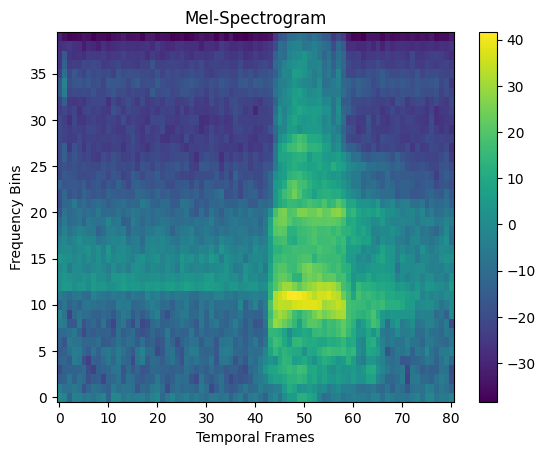

In [35]:
def extract_mel_spectrogram(wav, n_mels, n_fft, window_length, hop_length):
    # TASK 3: Implement mel scale transform here.
    to_mel_scale = torchaudio.transforms.MelScale(n_mels=n_mels) #: < - implement the correct argument calls here!
    spectrogram = extract_spectrogram(wav, n_fft, window_length, hop_length)
    mel_spectrogram = to_mel_scale(spectrogram)
    return mel_spectrogram

# Arguments required for mel-spectrogram computation. Feel free to play with them.
N_MELS = 40 # Number of Mel bands. Controls the number of frequency bins in the mel-spectrogram. A higher number gives more frequency detail.
mel_spectrogram = extract_mel_spectrogram(waveform, n_mels=N_MELS, n_fft=N_FFT, window_length=WIN_LENGTH, hop_length=HOP_LENGTH)

assert len(mel_spectrogram.shape) == 3

print(f"Mel-Spectrogram shape is {mel_spectrogram.shape}")
print(f"Dimension 0 is {mel_spectrogram.shape[0]}, which means there is one mel-spectrogram in this tensor batch.")
print(f"Dimension 1 is {mel_spectrogram.shape[1]}, which means that there are {mel_spectrogram.shape[1]} mel frequency bins.")
print(f"Dimension 2 is {mel_spectrogram.shape[2]}, which means that there are {mel_spectrogram.shape[2]} temporal frames.")

plot_spectrogram(mel_spectrogram[0, :, :], title="Mel-Spectrogram")

✍️ **TASK 4** (+0.75/10) - Finally, let's explore the MFCC. Use **torchaudio.transforms.MFCC** function for that, [see the documentation here.](https://pytorch.org/audio/main/generated/torchaudio.transforms.MFCC.html#torchaudio.transforms.MFCC)

MFCCshape is torch.Size([1, 13, 81])
Dimension 0 is 1, which means there is one MFCC in this tensor batch.
Dimension 1 is 13, which means that there are 13 MFCC bins.
Dimension 2 is 81, which means that there are 81 temporal frames.


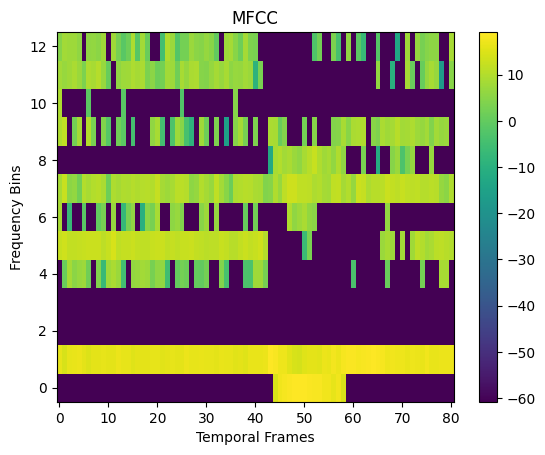

In [40]:
def extract_mfcc(wav, n_mfcc, mel_kwargs):
    # TASK 4: Implement MFCC extractor here.
    mfcc_extractor = torchaudio.transforms.MFCC(n_mfcc=n_mfcc, melkwargs= mel_kwargs) # <- implement the correct arguments in this call
    mfcc = mfcc_extractor(wav)
    return mfcc

N_MFCC = 13
MEL_KWARGS = {"n_mels": N_MELS, "n_fft": N_FFT, "win_length": WIN_LENGTH, "hop_length": HOP_LENGTH}
mfcc = extract_mfcc(waveform, n_mfcc=N_MFCC, mel_kwargs=MEL_KWARGS)

assert len(mfcc.shape) == 3

print(f"MFCCshape is {mfcc.shape}")
print(f"Dimension 0 is {mfcc.shape[0]}, which means there is one MFCC in this tensor batch.")
print(f"Dimension 1 is {mfcc.shape[1]}, which means that there are {mfcc.shape[1]} MFCC bins.")
print(f"Dimension 2 is {mfcc.shape[2]}, which means that there are {mfcc.shape[2]} temporal frames.")

plot_spectrogram(mfcc[0, :, :], title="MFCC")

Just to foster discussion and thought, let's take a look at the different audio representations (features) we've extracted. Particularly, let's focus on how many samples (numbers) does each one require to characterise our one second input audio.

In [42]:
print(f"Raw audio waveform shape = {waveform.shape} | Channels = {waveform.shape[0]} | Temporal frames = {waveform.shape[1]} | Total samples = {waveform.shape[0] * waveform.shape[1]}")
print(f"Spectrogram shape = {spectrogram.shape} | Channels = {spectrogram.shape[1]} | Temporal frames = {spectrogram.shape[2]} | Total samples = {spectrogram.shape[1] * spectrogram.shape[2]}")
print(f"Mel-Spectrogram shape = {mel_spectrogram.shape} | Channels = {mel_spectrogram.shape[1]} | Temporal frames = {mel_spectrogram.shape[2]} | Total samples = {mel_spectrogram.shape[1] * mel_spectrogram.shape[2]}")
print(f"MFCC shape = {mfcc.shape} | Channels = {mfcc.shape[1]} | Temporal frames = {mfcc.shape[2]} | Total samples = {mfcc.shape[1] * mfcc.shape[2]}")

Raw audio waveform shape = torch.Size([1, 16000]) | Channels = 1 | Temporal frames = 16000 | Total samples = 16000
Spectrogram shape = torch.Size([1, 201, 81]) | Channels = 201 | Temporal frames = 81 | Total samples = 16281
Mel-Spectrogram shape = torch.Size([1, 40, 81]) | Channels = 40 | Temporal frames = 81 | Total samples = 3240
MFCC shape = torch.Size([1, 13, 81]) | Channels = 13 | Temporal frames = 81 | Total samples = 1053


That's it! We have onboarded on speech audio features. This will be useful from now onwards, where we will learn about speech recognition and synthesis for conversational agents. Keep this lesson in mind if you ever also work on general audio.